## Installation and importing¶

In [13]:
! pip install tensorflow
! pip install tensorflow_probability
! pip install tabulate
! pip install tables
! pip install statsmodels
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [33]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_probability as tfp
ds = tfp.distributions

from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.preprocessing import MinMaxScaler
from scipy import signal

from tabulate import tabulate
import optuna

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print("Keras version " + tf.keras.__version__)
print("Tensorflow version " + tf.__version__)

# Helper functions
def minmax(x):
    return MinMaxScaler().fit_transform(np.atleast_2d(x).T).T[0]

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

Keras version 2.11.0
Tensorflow version 2.11.0


### Autoencoder

In [41]:
# Dataset parameters
n_window = 80             # input window
train_ratio = 0.8

def samples_unsupervised(s, n_window): 
    x = []
    for i in range(n_window, len(s)):
        x.append(s[i - n_window : i])
    
    return np.stack(x)

def train_test_split(x, train_ratio):
    t = int(len(x)*train_ratio)
    return x[0:t, :], x[t:, :]

class VAE(tf.keras.Model):

    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        
# Model parameters
tf.keras.backend.set_image_data_format("channels_last")
n_z = 2   # embedding dimensionality
        
encoder = [
    tf.keras.layers.InputLayer( input_shape=(n_window, 1) ),
    tf.keras.layers.Conv1D(
        filters=4, kernel_size=3, activation="relu"
    ),
    tf.keras.layers.Conv1D(
        filters=8, kernel_size=3, activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=n_z*2),
]

decoder = [
    tf.keras.layers.Dense(units=20 * 8, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(20, 8)),
    tf.keras.layers.Conv1DTranspose(
        filters=8, kernel_size=3, strides=(2,), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv1DTranspose(
        filters=4, kernel_size=3, strides=(2,), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv1DTranspose(
        filters=1, kernel_size=3, strides=(1,), padding="SAME", activation="linear"
    ),
]


### Data Preparation

In [69]:
train = pd.read_csv('iot_dataset/phase2_train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train['KPI ID'] = train['KPI ID'].astype(str)

labels = pd.read_hdf('iot_dataset/phase2_ground_truth.hdf')
labels['timestamp'] = pd.to_datetime(labels['timestamp'], unit='s')
labels['KPI ID'] = labels['KPI ID'].astype(str)

## Experiment 1: 42d6616d-c9c5-370a-a8ba-17ead74f3114

In [17]:
def create_train_test_part(train, labels, kpi_id):
    df_train = train[train['KPI ID'] == kpi_id]
    df_test = labels[labels['KPI ID'] == kpi_id]

    df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
    df_train.set_index('timestamp', inplace=True)
    start_date = df_train.index.min()
    end_date = start_date + pd.Timedelta(days=60)
    first_60_days_df = df_train.loc[start_date:end_date].reset_index()
    
    #interpolate outliers to create normal data for training
    first_60_days_df.loc[first_60_days_df['label'] == 1, 'value'] = np.nan
    first_60_days_df['value'] = first_60_days_df['value'].interpolate()
    first_60_days_df['label'] = 0
    
    mask = (df_train.index >= start_date) & (df_train.index <= end_date)
    df_train_above_60_days = df_train.loc[~mask].reset_index()

    df_test = pd.concat([df_train_above_60_days, df_test], ignore_index=True)
    df_test = df_test.sort_values(by='timestamp')
    df_train = first_60_days_df
    
    return df_train, df_test

In [18]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='42d6616d-c9c5-370a-a8ba-17ead74f3114')

In [19]:
def train_test_chart(df_train, df_test):    
    plt.figure(figsize=(14, 7))
    plt.plot(df_train['timestamp'], df_train['value'], label='train', color='green')
    plt.plot(df_test['timestamp'], df_test['value'], label='test')

    anomalies_true = df_test[df_test['label'] == 1]
    plt.scatter(anomalies_true['timestamp'], anomalies_true['value'], color='red', label='anomalies')
    plt.title(f'Train - Test split with Anomalies')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

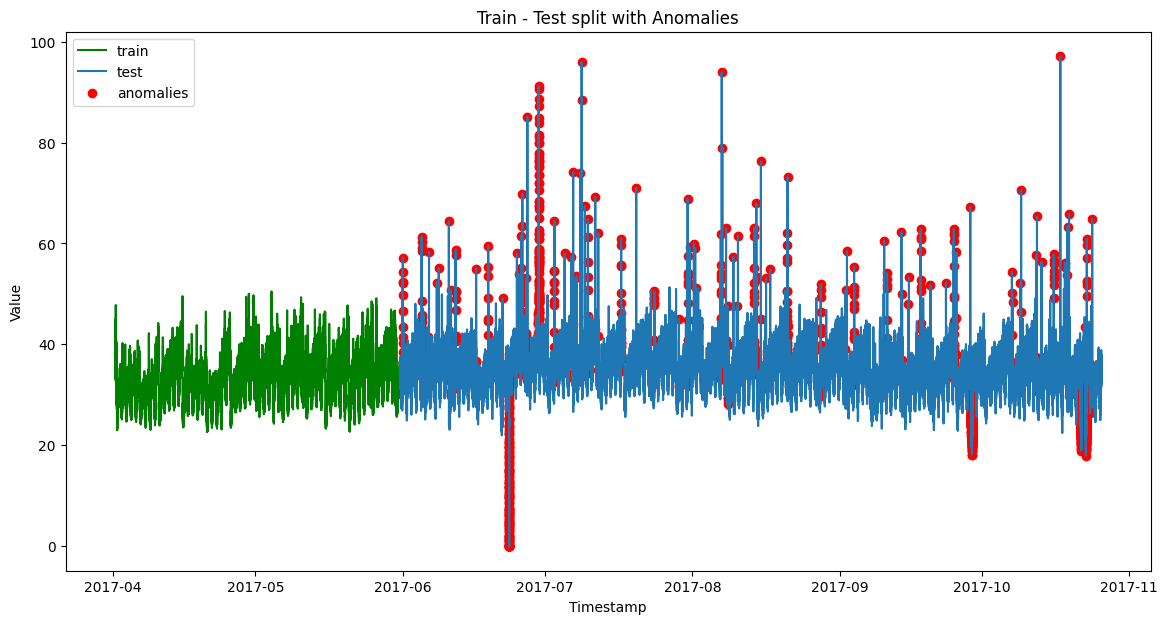

In [20]:
train_test_chart(df_train, df_test)

#### Model training

In [23]:
def model_training(df_train, train_buf, batch_size, n_train_batches):
    
    x = samples_unsupervised(df_train['value'].values, n_window)
    x_train, x_test = train_test_split(x, train_ratio)
    
    train_samples = x_train.reshape(x_train.shape[0], n_window, 1).astype("float32")
    train_dataset = (
        tf.data.Dataset.from_tensor_slices(train_samples)
        .shuffle(train_buf)
        .batch(batch_size)
    )
    
    # Model training
    optimizer = tf.keras.optimizers.Adam(1e-3)
    model_vae = VAE(
        enc = encoder,
        dec = decoder,
        optimizer = optimizer,
    )

    n_epochs = 100
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}...')
        for batch, train_x in zip(range(n_train_batches), train_dataset):
            model_vae.train(train_x)
            
    return model_vae

In [24]:
TRAIN_BUF = 60000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)

model_vae = model_training(df_train, train_buf=TRAIN_BUF, batch_size=BATCH_SIZE, n_train_batches=N_TRAIN_BATCHES)

2023-07-19 07:05:38.016682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-19 07:05:38.022645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-94-233.ec2.internal): /proc/driver/nvidia/version does not exist
2023-07-19 07:05:38.044107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 0...
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...
Epoch 25...
Epoch 26...
Epoch 27...
Epoch 28...
Epoch 29...
Epoch 30...
Epoch 31...
Epoch 32...
Epoch 33...
Epoch 34...
Epoch 35...
Epoch 36...
Epoch 37...
Epoch 38...
Epoch 39...
Epoch 40...
Epoch 41...
Epoch 42...
Epoch 43...
Epoch 44...
Epoch 45...
Epoch 46...
Epoch 47...
Epoch 48...
Epoch 49...
Epoch 50...
Epoch 51...
Epoch 52...
Epoch 53...
Epoch 54...
Epoch 55...
Epoch 56...
Epoch 57...
Epoch 58...
Epoch 59...
Epoch 60...
Epoch 61...
Epoch 62...
Epoch 63...
Epoch 64...
Epoch 65...
Epoch 66...
Epoch 67...
Epoch 68...
Epoch 69...
Epoch 70...
Epoch 71...
Epoch 72...
Epoch 73..

#### Model evaluation

In [25]:
def model_evaluation(df_test, model_vae):
    test_dataset = df_test['value'].values
    x = samples_unsupervised(test_dataset, n_window)
    x_hat = model_vae.reconstruct(np.atleast_3d(x)).numpy()[:, :, 0]

    pos = int(n_window-1)   # take the middle sample from the window

    test_dataset = df_test.iloc[pos: ,]
    test_dataset = test_dataset.iloc[0:-1]
    test_dataset['predicted'] = x_hat[:, pos]
    test_dataset['se'] = np.square(test_dataset['value'] - test_dataset['predicted'])
    
    return test_dataset

In [26]:
evaluation_dataset = model_evaluation(df_test, model_vae)

2023-07-19 07:15:31.947478: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 262217280 exceeds 10% of free system memory.
2023-07-19 07:15:33.597439: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 262217280 exceeds 10% of free system memory.
2023-07-19 07:15:33.883553: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 262217280 exceeds 10% of free system memory.
2023-07-19 07:15:34.090116: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 510987520 exceeds 10% of free system memory.
2023-07-19 07:15:36.260949: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 510987520 exceeds 10% of free system memory.


#### Threshold optimization

In [62]:
def find_threshold(df):   
    from sklearn.metrics import f1_score

    def objective(trial):
        threshold = trial.suggest_uniform('threshold', 0, 600)  # Adjust the range as per your requirements

        # Apply the threshold for anomaly detection
        df['label_predicted'] = np.where(df['se'] > threshold, 1, 0)

        # Calculate the F1-score
        f1 = f1_score(df['label'], df['label_predicted'])
        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_threshold = study.best_params['threshold']

    # Apply the best threshold for anomaly detection
    df['label_predicted'] = np.where(df['se'] > best_threshold, 1, 0)
    
    return df, best_threshold

In [63]:
evaluation_dataset, best_threshold = find_threshold(evaluation_dataset)

[I 2023-07-19 07:39:07,699] A new study created in memory with name: no-name-eb11cbd7-ff6e-4eef-9070-4add0dcff65b
[I 2023-07-19 07:39:07,785] Trial 0 finished with value: 0.12404712404712405 and parameters: {'threshold': 175.76379656952957}. Best is trial 0 with value: 0.12404712404712405.
[I 2023-07-19 07:39:07,873] Trial 1 finished with value: 0.08469912668979543 and parameters: {'threshold': 508.64927372017445}. Best is trial 0 with value: 0.12404712404712405.
[I 2023-07-19 07:39:07,964] Trial 2 finished with value: 0.08869814020028613 and parameters: {'threshold': 457.44054905166513}. Best is trial 0 with value: 0.12404712404712405.
[I 2023-07-19 07:39:08,062] Trial 3 finished with value: 0.09137418203450327 and parameters: {'threshold': 424.33656816373446}. Best is trial 0 with value: 0.12404712404712405.
[I 2023-07-19 07:39:08,152] Trial 4 finished with value: 0.11337921381080135 and parameters: {'threshold': 234.65608514805018}. Best is trial 0 with value: 0.12404712404712405.
[

In [29]:
best_threshold

77.58745746126235

#### Model evaluation results

In [30]:
def evaluation_chart(df):
    plt.figure(figsize=(14, 7))
    
    plt.plot(df['timestamp'], df['value'], label='Observed')
    plt.plot(df['timestamp'], df['predicted'], label=f'Forecast')
    anomalies_true = df[df['label'] == 1]
    plt.scatter(anomalies_true['timestamp'], anomalies_true['value'], color='red', label='true anomalies')
    anomalies_pred = df[df['label_predicted'] == 1]
    plt.scatter(anomalies_pred['timestamp'], anomalies_pred['value'], color='green', label='predicted anomalies')
    plt.legend()
    plt.show()

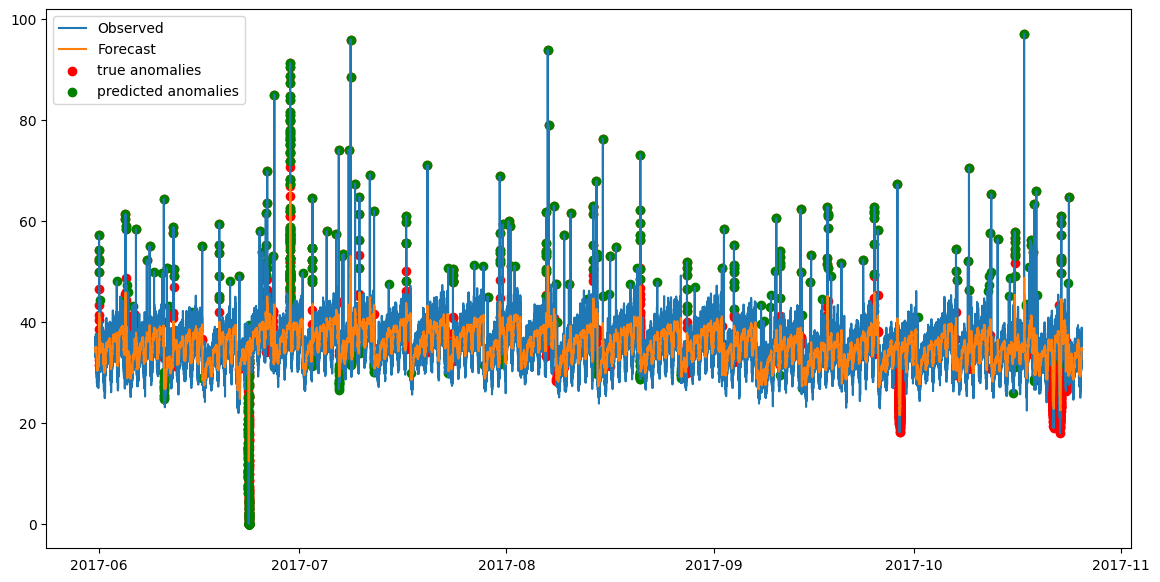

In [31]:
evaluation_chart(evaluation_dataset)

In [34]:
print(classification_report(evaluation_dataset['label'], evaluation_dataset['label_predicted']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    207591
           1       0.55      0.16      0.25      2519

    accuracy                           0.99    210110
   macro avg       0.77      0.58      0.62    210110
weighted avg       0.98      0.99      0.99    210110



**Precision** - Within everything that has been predicted as a positive, precision counts the percentage that is correct

<img src="images/Screenshot 2023-06-27 at 17.37.14.png" alt="Alternative text" />  

* A **not precise** model may find a lot of the positives, but its selection method is noisy: it also wrongly detects many positives that aren’t actually positives.  
* A **precise** model is very “pure”: maybe it does not find all the positives, but the ones that the model does class as positive are very likely to be correct.  
  
    
**Recall** - Within everything that actually is positive, how many did the model succeed to find
<img src="images/Screenshot 2023-06-27 at 17.37.19.png" alt="Alternative text" />  

* A model with **high recall** succeeds well in finding all the positive cases in the data, even though they may also wrongly identify some negative cases as positive cases.  
* A model with **low recall** is not able to find all (or a large part) of the positive cases in the data.
  
    
**F1** - The goal of the F1 score is to combine the precision and recall metrics into a single metric. At the same time, the F1 score has been designed to work well on imbalanced data.  
<img src="images/Screenshot 2023-06-27 at 17.37.26.png" alt="Alternative text" />   

* A model will obtain a **high F1 score** if both Precision and Recall are high
* A model will obtain a **low F1 score** if both Precision and Recall are low
* A model will obtain a **medium F1 score** if one of Precision and Recall is low and the other is high


### Parameters optimization

In [14]:
x = samples_unsupervised(first_60_days_df['value'].values, n_window)
x_train, x_test = train_test_split(x, train_ratio)

TRAIN_BUF = 60000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
train_samples = x_train.reshape(x_train.shape[0], n_window, 1).astype("float32")
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_samples)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

In [ ]:
import optuna
from sklearn.metrics import f1_score

def objective_model(trial):
    # Define the search space for model hyperparameters
    n_filters = trial.suggest_int('n_filters', 2, 10)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Update your model architecture and parameters with the suggested hyperparameters
    encoder = [
        tf.keras.layers.InputLayer( input_shape=(n_window, 1) ),
    tf.keras.layers.Conv1D(
        filters=n_filters, kernel_size=kernel_size, activation="relu"
    ),
    tf.keras.layers.Conv1D(
        filters=n_filters, kernel_size=kernel_size, activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(units=n_z*2),
    ]
    
    decoder = [
        tf.keras.layers.Dense(units=20 * 8, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(20, 8)),
    tf.keras.layers.Conv1DTranspose(
        filters=n_filters, kernel_size=kernel_size, strides=(2,), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv1DTranspose(
        filters=n_filters, kernel_size=kernel_size, strides=(2,), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv1DTranspose(
        filters=n_filters, kernel_size=kernel_size, strides=(1,), padding="SAME", activation="linear"
    ),
    ]

    model_vae = VAE(
        enc=encoder,
        dec=decoder,
        optimizer=tf.keras.optimizers.Adam(learning_rate),
    )
    
    
    x = samples_unsupervised(first_60_days_df['value'].values, n_window)
    x_train, x_test = train_test_split(x, train_ratio)

    TRAIN_BUF = 60000
    BATCH_SIZE = batch_size
    N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
    train_samples = x_train.reshape(x_train.shape[0], n_window, 1).astype("float32")
    train_dataset = (
        tf.data.Dataset.from_tensor_slices(train_samples)
        .shuffle(TRAIN_BUF)
        .batch(BATCH_SIZE)
    )

    # Train the model
    n_epochs = 100
    for epoch in range(n_epochs):
        for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
            model_vae.train(train_x)


    
    test_dataset = test_part['value'].values
    # Perform inference and compute metrics
    x = samples_unsupervised(test_dataset, n_window)
    x_hat = model_vae.reconstruct(np.atleast_3d(x)).numpy()[:, :, 0]
    print(x.shape, x_hat.shape)

    pos = int(n_window-1)   # take the middle sample from the window

    test_dataset = test_part.iloc[pos: ,]
    test_dataset_pred = test_dataset.iloc[0:-1]
    test_dataset_pred['predicted'] = x_hat[:, pos]
    test_dataset_pred['se'] = np.square(test_dataset_pred['value'] - test_dataset_pred['predicted'])

    # Return the metric you want to optimize (e.g., F1 score)
    return f1_score(test_dataset_pred['label'], np.where(test_dataset_pred['se'] > best_threshold, 1, 0))

def objective_threshold(trial):
    threshold = trial.suggest_uniform('threshold', 0.0, 400.0)  # Adjust the range as per your requirements
    
    # Apply the threshold for anomaly detection
    test_dataset_pred['label_predicted'] = np.where(test_dataset_pred['se'] > threshold, 1, 0)
    
    # Calculate the F1-score
    return f1_score(test_dataset_pred['label'], test_dataset_pred['label_predicted'])

# Model hyperparameter optimization
study_model = optuna.create_study(direction='maximize')
study_model.optimize(objective_model, n_trials=20)

# Get the best hyperparameters for the model
best_params_model = study_model.best_params

[I 2023-07-05 10:05:57,510] A new study created in memory with name: no-name-40a05192-0aac-4847-87c8-b5a0e2aa5e95
[I 2023-07-05 10:14:59,769] Trial 0 finished with value: 0.0 and parameters: {'n_filters': 2, 'kernel_size': 3, 'dropout_rate': 0.1299220345131955, 'learning_rate': 3.463134319985306e-05, 'batch_size': 64}. Best is trial 0 with value: 0.0.


(210110, 80) (210110, 80)


[I 2023-07-05 10:26:30,961] Trial 1 finished with value: 0.28988410359135786 and parameters: {'n_filters': 7, 'kernel_size': 4, 'dropout_rate': 0.48403220049863804, 'learning_rate': 0.003997331233747782, 'batch_size': 64}. Best is trial 1 with value: 0.28988410359135786.


(210110, 80) (210110, 80)


[I 2023-07-05 10:45:18,074] Trial 2 finished with value: 0.2184873949579832 and parameters: {'n_filters': 6, 'kernel_size': 5, 'dropout_rate': 0.4954439534960977, 'learning_rate': 0.00027794992780218934, 'batch_size': 16}. Best is trial 1 with value: 0.28988410359135786.


(210110, 80) (210110, 80)


[I 2023-07-05 10:58:13,776] Trial 3 finished with value: 0.24869451697127934 and parameters: {'n_filters': 7, 'kernel_size': 3, 'dropout_rate': 0.4916811575262754, 'learning_rate': 0.000610313962972737, 'batch_size': 32}. Best is trial 1 with value: 0.28988410359135786.


(210110, 80) (210110, 80)


[I 2023-07-05 11:08:24,864] Trial 4 finished with value: 0.25217671718800383 and parameters: {'n_filters': 3, 'kernel_size': 3, 'dropout_rate': 0.46146518284773996, 'learning_rate': 2.0394712092160965e-05, 'batch_size': 32}. Best is trial 1 with value: 0.28988410359135786.


(210110, 80) (210110, 80)


[I 2023-07-05 11:18:21,666] Trial 5 finished with value: 0.0 and parameters: {'n_filters': 2, 'kernel_size': 4, 'dropout_rate': 0.2696592395278683, 'learning_rate': 1.576914998719228e-05, 'batch_size': 32}. Best is trial 1 with value: 0.28988410359135786.


(210110, 80) (210110, 80)


In [62]:
best_params_model

{'n_filters': 7,
 'kernel_size': 3,
 'dropout_rate': 0.2417554157457356,
 'learning_rate': 0.007174332590480936,
 'batch_size': 16}

### Experiment 2: 301c70d8-1630-35ac-8f96-bc1b6f4359ea

#### Dataset preparation

In [35]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='301c70d8-1630-35ac-8f96-bc1b6f4359ea')

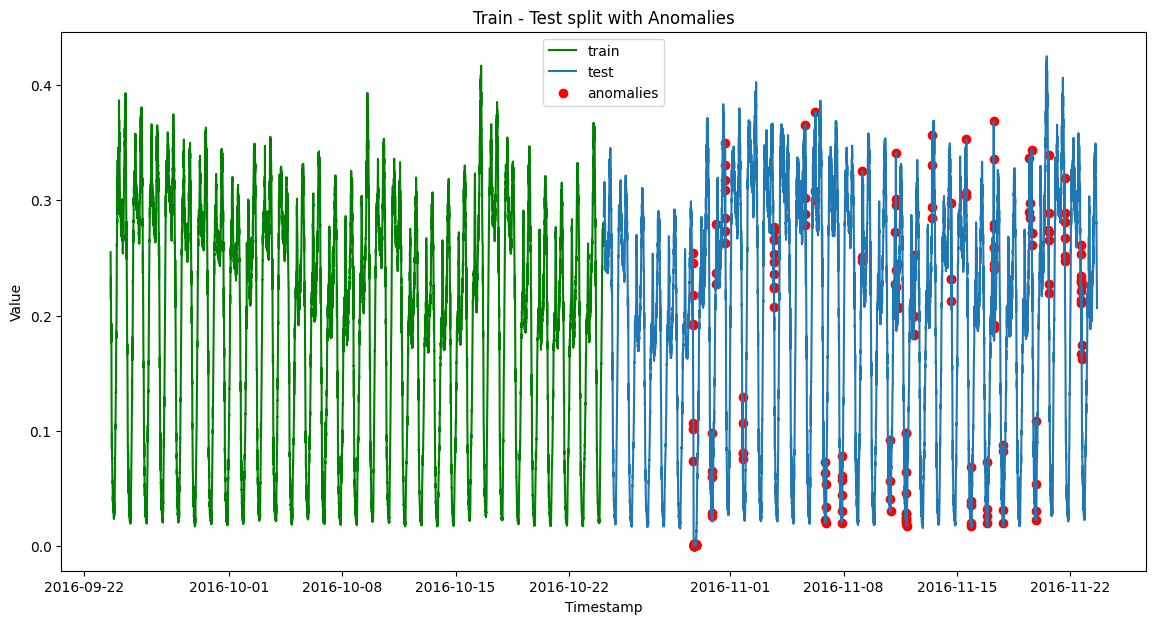

In [36]:
train_test_chart(df_train, df_test)

#### Model training

In [42]:
TRAIN_BUF = 60000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)

model_vae = model_training(df_train, train_buf=TRAIN_BUF, batch_size=BATCH_SIZE, n_train_batches=N_TRAIN_BATCHES)

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...
Epoch 25...
Epoch 26...
Epoch 27...
Epoch 28...
Epoch 29...
Epoch 30...
Epoch 31...
Epoch 32...
Epoch 33...
Epoch 34...
Epoch 35...
Epoch 36...
Epoch 37...
Epoch 38...
Epoch 39...
Epoch 40...
Epoch 41...
Epoch 42...
Epoch 43...
Epoch 44...
Epoch 45...
Epoch 46...
Epoch 47...
Epoch 48...
Epoch 49...
Epoch 50...
Epoch 51...
Epoch 52...
Epoch 53...
Epoch 54...
Epoch 55...
Epoch 56...
Epoch 57...
Epoch 58...
Epoch 59...
Epoch 60...
Epoch 61...
Epoch 62...
Epoch 63...
Epoch 64...
Epoch 65...
Epoch 66...
Epoch 67...
Epoch 68...
Epoch 69...
Epoch 70...
Epoch 71...
Epoch 72...
Epoch 73...
Epoch 74...
Epoch 75...
Epoch 76...
Epoch 77...
Epoch 78...
Epoch 79...
Epoch 80...
Epoch 81...
Epoch 82...
Epoch 83...
Ep

#### Model evaluation

In [46]:
evaluation_dataset = model_evaluation(df_test, model_vae)

#### Threhold optimization

In [52]:
evaluation_dataset, best_threshold = find_threshold(evaluation_dataset)

[I 2023-07-19 07:25:23,416] A new study created in memory with name: no-name-7f78738e-dfbe-4c99-8787-54b7776cb9e2
[I 2023-07-19 07:25:23,427] Trial 0 finished with value: 0.02775368603642671 and parameters: {'threshold': 0.011459037573323021}. Best is trial 0 with value: 0.02775368603642671.
[I 2023-07-19 07:25:23,435] Trial 1 finished with value: 0.028248587570621465 and parameters: {'threshold': 0.012068804755614199}. Best is trial 1 with value: 0.028248587570621465.
[I 2023-07-19 07:25:23,443] Trial 2 finished with value: 0.046490004649000466 and parameters: {'threshold': 0.0060852484824915915}. Best is trial 2 with value: 0.046490004649000466.
[I 2023-07-19 07:25:23,450] Trial 3 finished with value: 0.028037383177570097 and parameters: {'threshold': 0.012025114206214455}. Best is trial 2 with value: 0.046490004649000466.
[I 2023-07-19 07:25:23,459] Trial 4 finished with value: 0.02399127589967285 and parameters: {'threshold': 0.013251285665918532}. Best is trial 2 with value: 0.046

In [53]:
best_threshold

0.0056264985686537

#### Model evaluation results

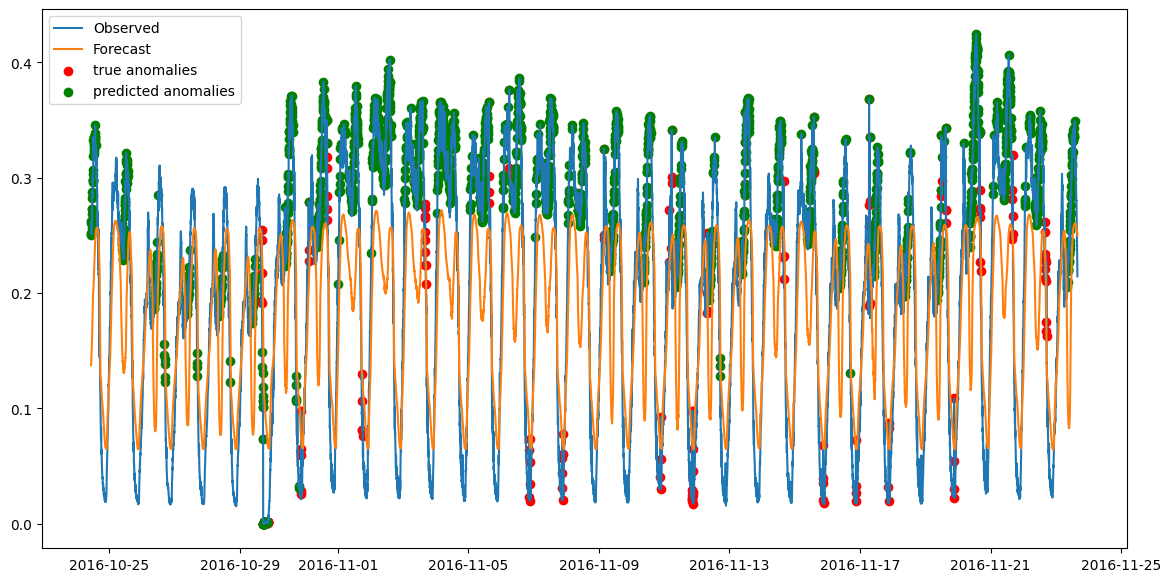

In [48]:
evaluation_chart(evaluation_dataset)

In [50]:
print(classification_report(evaluation_dataset['label'], evaluation_dataset['label_predicted']))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85      8498
           1       0.03      0.28      0.05       206

    accuracy                           0.75      8704
   macro avg       0.50      0.52      0.45      8704
weighted avg       0.96      0.75      0.84      8704



## Experiment 3: f0932edd-6400-3e63-9559-0a9860a1baa9

#### Dataset preparation

In [54]:
df_train, df_test = create_train_test_part(train, labels, kpi_id='f0932edd-6400-3e63-9559-0a9860a1baa9')

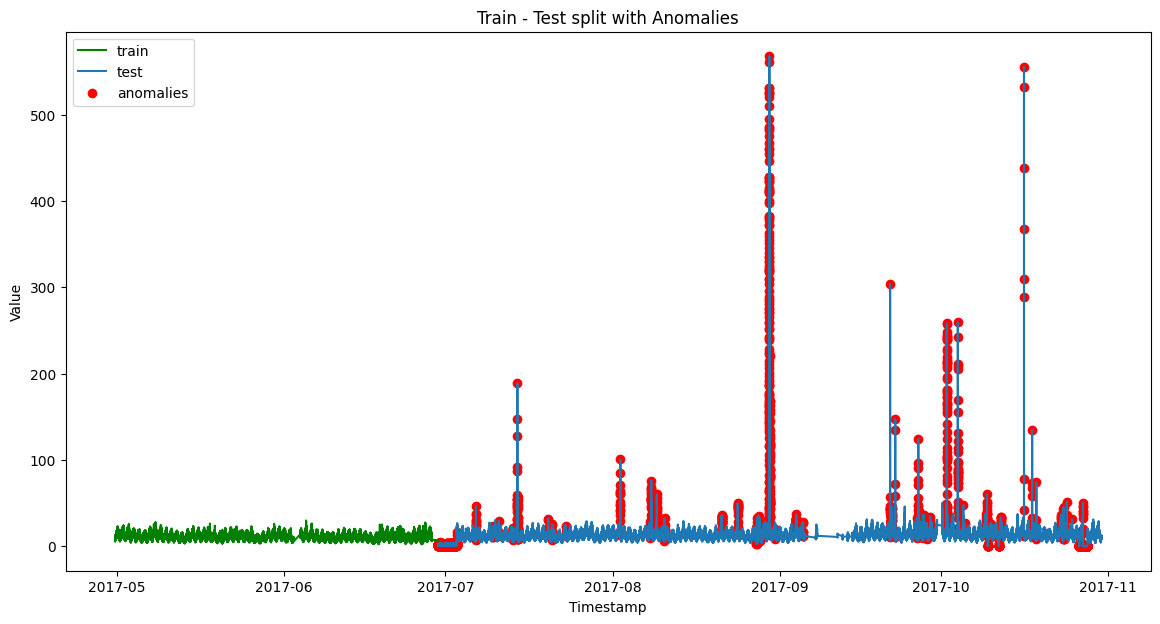

In [55]:
train_test_chart(df_train, df_test)

#### Model training

In [56]:
TRAIN_BUF = 60000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)

model_vae = model_training(df_train, train_buf=TRAIN_BUF, batch_size=BATCH_SIZE, n_train_batches=N_TRAIN_BATCHES)

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...
Epoch 25...
Epoch 26...
Epoch 27...
Epoch 28...
Epoch 29...
Epoch 30...
Epoch 31...
Epoch 32...
Epoch 33...
Epoch 34...
Epoch 35...
Epoch 36...
Epoch 37...
Epoch 38...
Epoch 39...
Epoch 40...
Epoch 41...
Epoch 42...
Epoch 43...
Epoch 44...
Epoch 45...
Epoch 46...
Epoch 47...
Epoch 48...
Epoch 49...
Epoch 50...
Epoch 51...
Epoch 52...
Epoch 53...
Epoch 54...
Epoch 55...
Epoch 56...
Epoch 57...
Epoch 58...
Epoch 59...
Epoch 60...
Epoch 61...
Epoch 62...
Epoch 63...
Epoch 64...
Epoch 65...
Epoch 66...
Epoch 67...
Epoch 68...
Epoch 69...
Epoch 70...
Epoch 71...
Epoch 72...
Epoch 73...
Epoch 74...
Epoch 75...
Epoch 76...
Epoch 77...
Epoch 78...
Epoch 79...
Epoch 80...
Epoch 81...
Epoch 82...
Epoch 83...
Ep

#### Model evaluation

In [57]:
evaluation_dataset = model_evaluation(df_test, model_vae)

#### Threhold optimization

In [64]:
evaluation_dataset, best_threshold = find_threshold(evaluation_dataset)

[I 2023-07-19 07:39:22,185] A new study created in memory with name: no-name-782b6a08-1f41-4d91-af2a-a56865dd069f
[I 2023-07-19 07:39:22,353] Trial 0 finished with value: 0.08603178396463138 and parameters: {'threshold': 487.4564741470527}. Best is trial 0 with value: 0.08603178396463138.
[I 2023-07-19 07:39:22,515] Trial 1 finished with value: 0.1069543802040577 and parameters: {'threshold': 280.6943527088333}. Best is trial 1 with value: 0.1069543802040577.
[I 2023-07-19 07:39:22,694] Trial 2 finished with value: 0.13186561174177275 and parameters: {'threshold': 146.75305637224898}. Best is trial 2 with value: 0.13186561174177275.
[I 2023-07-19 07:39:22,860] Trial 3 finished with value: 0.10134338911147772 and parameters: {'threshold': 319.4151025029998}. Best is trial 2 with value: 0.13186561174177275.
[I 2023-07-19 07:39:22,962] Trial 4 finished with value: 0.08158368326334732 and parameters: {'threshold': 592.0319132955946}. Best is trial 2 with value: 0.13186561174177275.
[I 2023

#### Model evaluation results

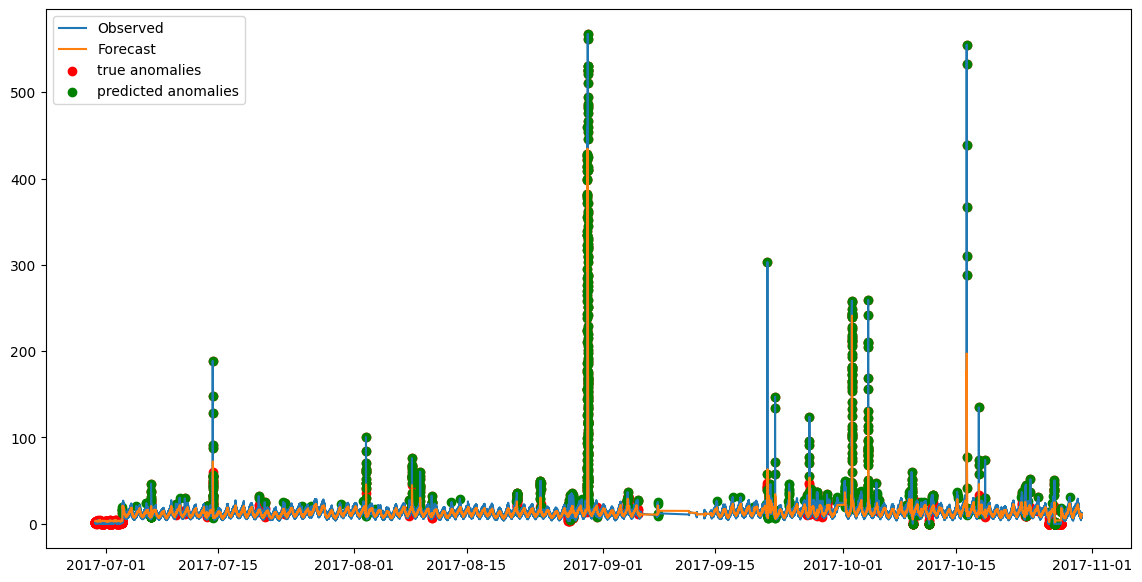

In [59]:
evaluation_chart(evaluation_dataset)

In [65]:
print(classification_report(evaluation_dataset['label'], evaluation_dataset['label_predicted']))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96    149586
           1       0.24      0.28      0.26      7841

    accuracy                           0.92    157427
   macro avg       0.60      0.62      0.61    157427
weighted avg       0.93      0.92      0.92    157427

